<a href="https://colab.research.google.com/github/agarr3/vajra-new-2/blob/main/AE_HYBRID_COMBINED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
reduction_loss = "mean"
if reduction_loss == "mean":
  criterion = nn.MSELoss(reduction="mean")
elif reduction_loss == "sum":
  criterion = nn.MSELoss(reduction="sum")
n_epochs = 30
print_every = 1

BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_COMBINED/"

input_bins = 48
seq_len=200
AE_encoded_dim = 64

class_level_loss_mode = "test"

print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins"
DATA_SONG_DIR = "Chunked"
DATA_IMG_DIR = "Chunked"

files = []
western_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_SONG_DIR, "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      western_files.append([file,file, "Western_numpy"])
    else:
      print(file)

# random.seed(1234)
# western_files = random.sample(western_files, 2008)

indian_files = []
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_SONG_DIR, "Indian_numpy")):
  for file in fileList:
    if(True):
      indian_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

files = indian_files + western_files
dataDF = pd.DataFrame(files, columns=['Images','songs','labels'])
dataDF.head()

,Images,songs,labels
0,indianNizhalinaiNijamum_mel_0.npy,indianNizhalinaiNijamum_mel_0.npy,Indian_numpy
1,indianNizhalinaiNijamum_mel_1.npy,indianNizhalinaiNijamum_mel_1.npy,Indian_numpy
2,indianOhOh_mel_0.npy,indianOhOh_mel_0.npy,Indian_numpy
3,indianOhOh_mel_1.npy,indianOhOh_mel_1.npy,Indian_numpy
4,indianOnnavittaYaarumYenakilla_mel_0.npy,indianOnnavittaYaarumYenakilla_mel_0.npy,Indian_numpy


In [7]:
dataDF.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,4016,4016
Western_numpy,4000,4000


/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Chunked/Indian_numpy/indianApnaSangeetVajeApnaSangeet_mel_0.npy
55.789955


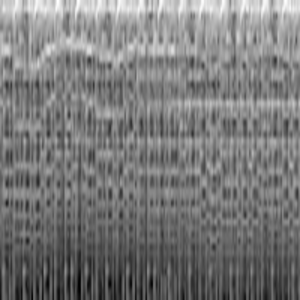

In [8]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, dataDF.loc[test_idx, 'labels'], dataDF.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



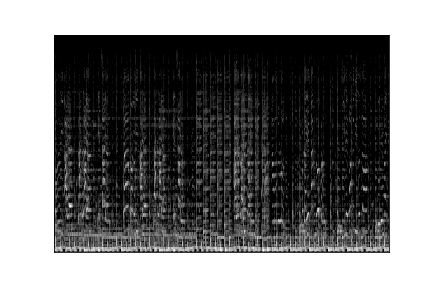

In [9]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [10]:
lb = LabelEncoder()
dataDF['encoded_labels'] = lb.fit_transform(dataDF['labels'])
dataDF.head()

,Images,songs,labels,encoded_labels
0,indianNizhalinaiNijamum_mel_0.npy,indianNizhalinaiNijamum_mel_0.npy,Indian_numpy,0
1,indianNizhalinaiNijamum_mel_1.npy,indianNizhalinaiNijamum_mel_1.npy,Indian_numpy,0
2,indianOhOh_mel_0.npy,indianOhOh_mel_0.npy,Indian_numpy,0
3,indianOhOh_mel_1.npy,indianOhOh_mel_1.npy,Indian_numpy,0
4,indianOnnavittaYaarumYenakilla_mel_0.npy,indianOnnavittaYaarumYenakilla_mel_0.npy,Indian_numpy,0


In [11]:
classes = ('Indian_numpy', 'Western_numpy')
dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,4016,4016
Western_numpy,1,4000,4000


In [12]:
from sklearn.model_selection import train_test_split

dataDF = dataDF.sample(frac=1)
df_train, df_test = train_test_split(dataDF, test_size=validation_split, stratify=dataDF[["labels"]], random_state=9)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


if class_level_loss_mode == "test":
  western_dataDF = df_test[df_test['labels'] == "Western_numpy"]
  western_dataDF = western_dataDF.reset_index(drop=True)
  indian_dataDF = df_test[df_test['labels'] == "Indian_numpy"]
  indian_dataDF = indian_dataDF.reset_index(drop=True)

In [13]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2811,2811
Western_numpy,1,2800,2800


In [14]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1205,1205
Western_numpy,1,1200,1200


In [15]:
indian_dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1205,1205


In [16]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [17]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        fileName = self.img_data.loc[index, 'Images']
        return data, label, fileName



In [18]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

In [19]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [20]:
indian_dataset = MEL_Dataset(indian_dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
western_dataset = MEL_Dataset(western_dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

indian_loader = torch.utils.data.DataLoader(indian_dataset, batch_size=batch_size)
western_loader = torch.utils.data.DataLoader(western_dataset, batch_size=batch_size)


In [21]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

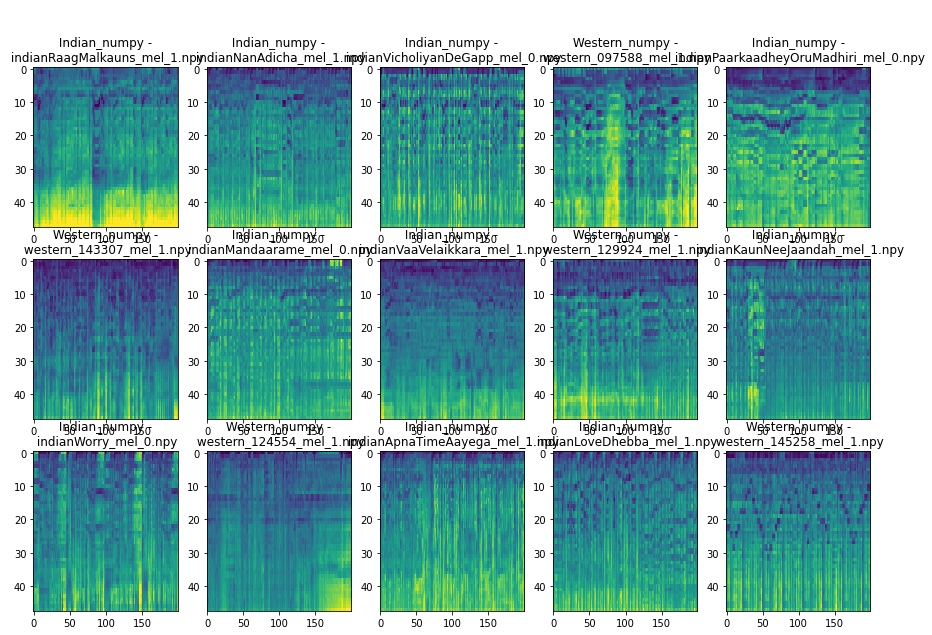

In [22]:
# get some random training images
dataiter = iter(trainloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label, fileName = images[i], labels[i], fileNames[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"\n \n {arthopod_types[label.item()]} - \n {fileName}") # add label

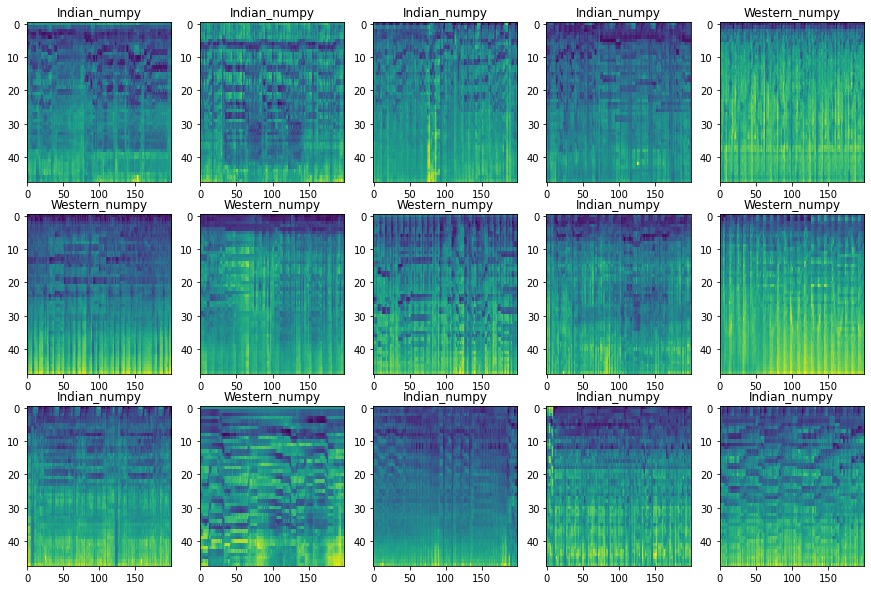

In [23]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

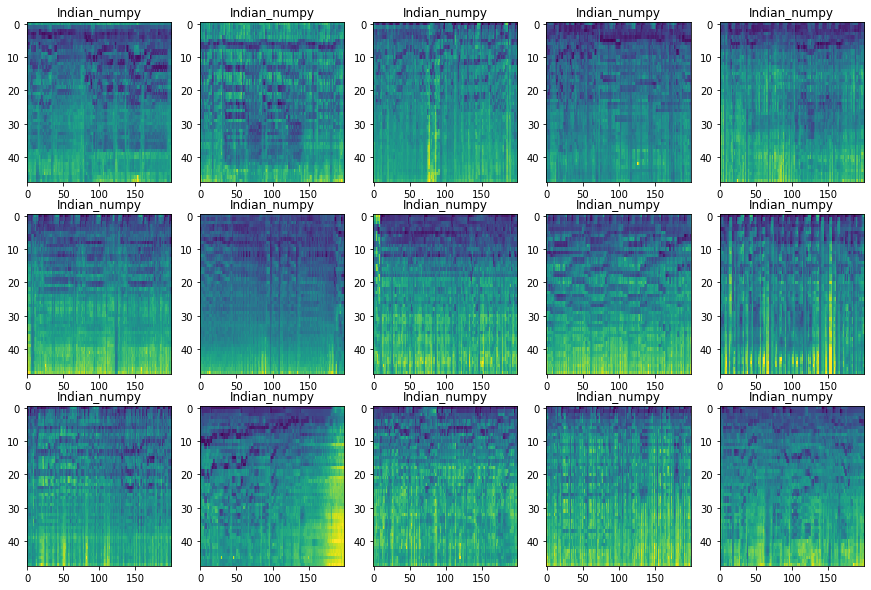

In [24]:
# get some random training images
dataiter = iter(indian_loader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

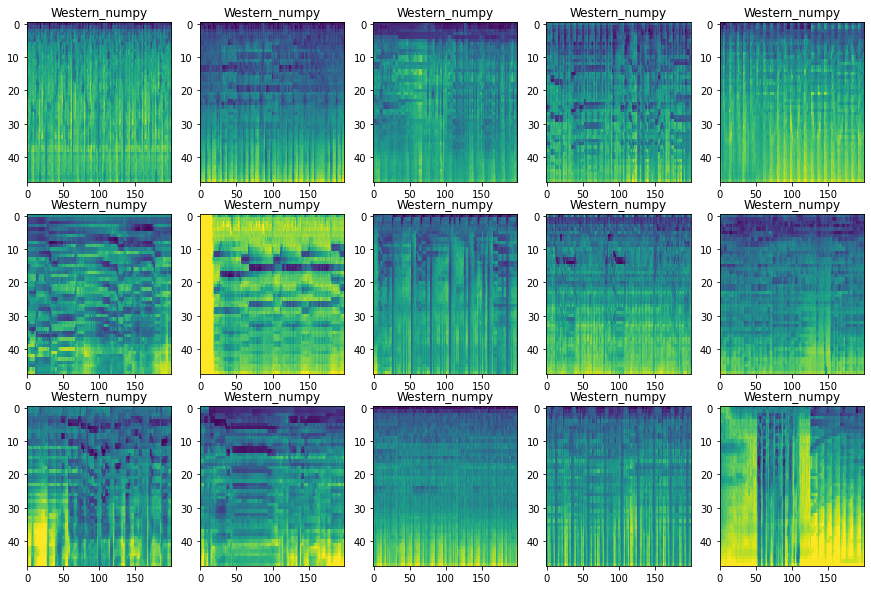

In [25]:
# get some random training images
dataiter = iter(western_loader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [26]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(42, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=9600, bias=True)
  )
)

In [27]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


def visualize_class_loss(in_loss_graph, we_loss_graph):
  x = range(len(in_loss_graph))
      
  # plot lines
  plt.plot(x, in_loss_graph, label = "Indian Loss")
  plt.plot(x, we_loss_graph, label = "Western Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1362.697
[1,     2] loss: 1460.109
[1,     3] loss: 1264.807
[1,     4] loss: 1185.001
[1,     5] loss: 1078.663
[1,     6] loss: 738.486
[1,     7] loss: 531.830
[1,     8] loss: 309.207
[1,     9] loss: 282.335
[1,    10] loss: 332.350
[1,    11] loss: 206.600
[1,    12] loss: 144.467
[1,    13] loss: 131.069
[1,    14] loss: 135.994
[1,    15] loss: 173.752
[1,    16] loss: 140.823
[1,    17] loss: 183.396
[1,    18] loss: 159.987
[1,    19] loss: 116.309
[1,    20] loss: 125.197
[1,    21] loss: 133.203
[1,    22] loss: 153.264
[1,    23] loss: 154.742
[1,    24] loss: 129.560
[1,    25] loss: 132.807
[1,    26] loss: 102.871
[1,    27] loss: 124.696
[1,    28] loss: 116.726
[1,    29] loss: 124.852
[1,    30] loss: 105.300
[1,    31] loss: 100.063
[1,    32] loss: 150.495
[1,    33] loss: 104.718
[1,    34] loss: 117.560
[1,    35] loss: 91.044
[1,    36] loss: 142.290
[1,    37] loss: 125.346
[1,    38] loss: 126.105
[1,    39] loss: 110.835
[1,    40] loss: 106.

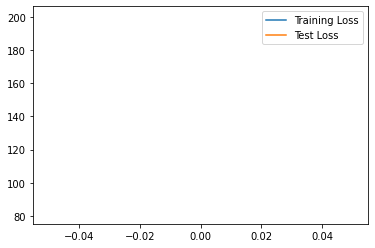

LOSS of the network on the test images: 1335 %
Mean of the network on the Indian images after epoch 0 is 74.16983328925238
LOSS of the network on the test images: 1673 %
Mean of the network on the Western images after epoch 0 is 92.95521079169379


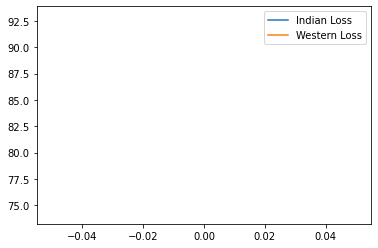

[2,     1] loss: 82.037
[2,     2] loss: 82.925
[2,     3] loss: 69.301
[2,     4] loss: 67.619
[2,     5] loss: 76.541
[2,     6] loss: 67.768
[2,     7] loss: 78.848
[2,     8] loss: 80.432
[2,     9] loss: 75.689
[2,    10] loss: 82.249
[2,    11] loss: 79.483
[2,    12] loss: 77.885
[2,    13] loss: 66.969
[2,    14] loss: 71.898
[2,    15] loss: 73.690
[2,    16] loss: 71.690
[2,    17] loss: 78.043
[2,    18] loss: 78.599
[2,    19] loss: 59.930
[2,    20] loss: 75.025
[2,    21] loss: 72.593
[2,    22] loss: 68.058
[2,    23] loss: 76.517
[2,    24] loss: 62.214
[2,    25] loss: 67.760
[2,    26] loss: 58.355
[2,    27] loss: 71.575
[2,    28] loss: 66.575
[2,    29] loss: 71.867
[2,    30] loss: 70.711
[2,    31] loss: 66.053
[2,    32] loss: 73.349
[2,    33] loss: 70.556
[2,    34] loss: 69.603
[2,    35] loss: 66.650
[2,    36] loss: 88.421
[2,    37] loss: 78.025
[2,    38] loss: 74.900
[2,    39] loss: 71.180
[2,    40] loss: 66.791
[2,    41] loss: 63.180
[2,    42] loss:

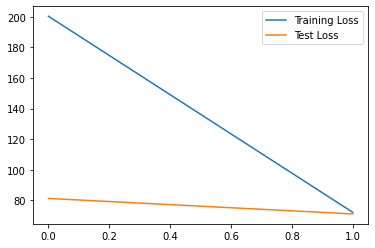

LOSS of the network on the test images: 1163 %
Mean of the network on the Indian images after epoch 1 is 64.65254402160645
LOSS of the network on the test images: 1469 %
Mean of the network on the Western images after epoch 1 is 81.63256115383572


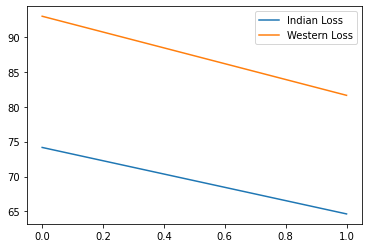

[3,     1] loss: 72.776
[3,     2] loss: 76.453
[3,     3] loss: 62.238
[3,     4] loss: 63.833
[3,     5] loss: 70.612
[3,     6] loss: 64.348
[3,     7] loss: 71.221
[3,     8] loss: 76.619
[3,     9] loss: 71.230
[3,    10] loss: 77.267
[3,    11] loss: 76.925
[3,    12] loss: 74.264
[3,    13] loss: 64.955
[3,    14] loss: 69.590
[3,    15] loss: 71.432
[3,    16] loss: 69.340
[3,    17] loss: 74.932
[3,    18] loss: 76.279
[3,    19] loss: 58.689
[3,    20] loss: 73.248
[3,    21] loss: 71.206
[3,    22] loss: 65.685
[3,    23] loss: 74.460
[3,    24] loss: 60.954
[3,    25] loss: 67.009
[3,    26] loss: 57.186
[3,    27] loss: 69.664
[3,    28] loss: 64.647
[3,    29] loss: 70.392
[3,    30] loss: 68.708
[3,    31] loss: 64.609
[3,    32] loss: 71.482
[3,    33] loss: 68.858
[3,    34] loss: 67.608
[3,    35] loss: 65.687
[3,    36] loss: 86.095
[3,    37] loss: 75.660
[3,    38] loss: 74.255
[3,    39] loss: 69.936
[3,    40] loss: 65.613
[3,    41] loss: 62.184
[3,    42] loss:

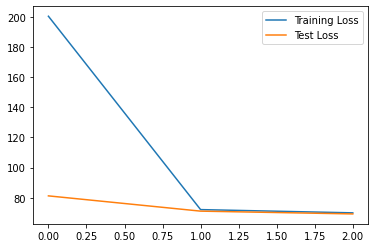

LOSS of the network on the test images: 1143 %
Mean of the network on the Indian images after epoch 2 is 63.54536332024468
LOSS of the network on the test images: 1421 %
Mean of the network on the Western images after epoch 2 is 78.94742605421278


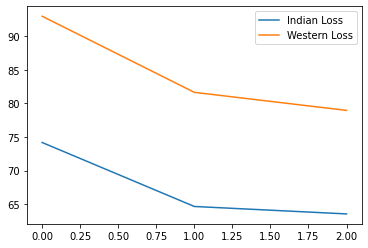

[4,     1] loss: 71.209
[4,     2] loss: 74.563
[4,     3] loss: 61.202
[4,     4] loss: 61.659
[4,     5] loss: 68.349
[4,     6] loss: 63.067
[4,     7] loss: 68.025
[4,     8] loss: 76.064
[4,     9] loss: 68.736
[4,    10] loss: 74.854
[4,    11] loss: 75.385
[4,    12] loss: 71.608
[4,    13] loss: 63.323
[4,    14] loss: 67.512
[4,    15] loss: 69.257
[4,    16] loss: 66.916
[4,    17] loss: 73.673
[4,    18] loss: 74.292
[4,    19] loss: 58.301
[4,    20] loss: 70.996
[4,    21] loss: 69.164
[4,    22] loss: 63.961
[4,    23] loss: 71.758
[4,    24] loss: 59.460
[4,    25] loss: 66.160
[4,    26] loss: 55.731
[4,    27] loss: 67.412
[4,    28] loss: 62.640
[4,    29] loss: 68.427
[4,    30] loss: 65.857
[4,    31] loss: 62.260
[4,    32] loss: 69.882
[4,    33] loss: 65.835
[4,    34] loss: 65.451
[4,    35] loss: 63.869
[4,    36] loss: 81.357
[4,    37] loss: 71.928
[4,    38] loss: 71.945
[4,    39] loss: 67.575
[4,    40] loss: 63.377
[4,    41] loss: 59.690
[4,    42] loss:

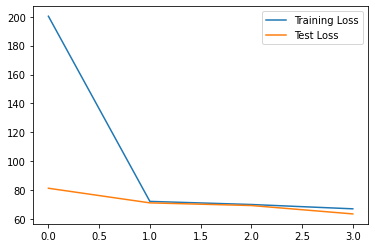

LOSS of the network on the test images: 1078 %
Mean of the network on the Indian images after epoch 3 is 59.92398092481825
LOSS of the network on the test images: 1270 %
Mean of the network on the Western images after epoch 3 is 70.5873572031657


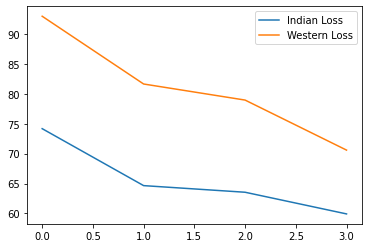

[5,     1] loss: 65.792
[5,     2] loss: 66.982
[5,     3] loss: 55.300
[5,     4] loss: 56.940
[5,     5] loss: 61.751
[5,     6] loss: 58.491
[5,     7] loss: 60.162
[5,     8] loss: 68.761
[5,     9] loss: 63.434
[5,    10] loss: 69.037
[5,    11] loss: 68.512
[5,    12] loss: 66.988
[5,    13] loss: 59.000
[5,    14] loss: 59.869
[5,    15] loss: 65.334
[5,    16] loss: 60.188
[5,    17] loss: 66.012
[5,    18] loss: 68.542
[5,    19] loss: 53.746
[5,    20] loss: 64.092
[5,    21] loss: 65.243
[5,    22] loss: 59.610
[5,    23] loss: 66.836
[5,    24] loss: 54.480
[5,    25] loss: 61.809
[5,    26] loss: 52.226
[5,    27] loss: 60.636
[5,    28] loss: 57.680
[5,    29] loss: 61.492
[5,    30] loss: 58.445
[5,    31] loss: 55.787
[5,    32] loss: 62.930
[5,    33] loss: 57.488
[5,    34] loss: 59.225
[5,    35] loss: 59.016
[5,    36] loss: 70.110
[5,    37] loss: 61.839
[5,    38] loss: 63.387
[5,    39] loss: 60.636
[5,    40] loss: 56.986
[5,    41] loss: 55.072
[5,    42] loss:

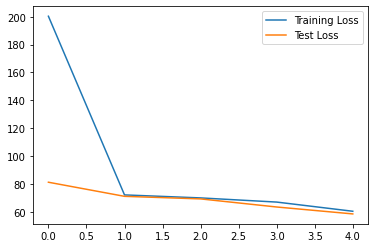

LOSS of the network on the test images: 1026 %
Mean of the network on the Indian images after epoch 4 is 57.025794982910156
LOSS of the network on the test images: 1138 %
Mean of the network on the Western images after epoch 4 is 63.24865362379286


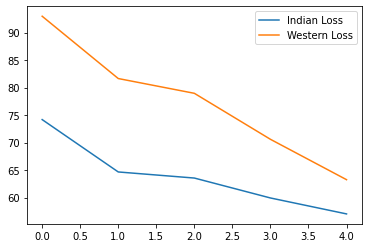

[6,     1] loss: 60.819
[6,     2] loss: 61.167
[6,     3] loss: 50.568
[6,     4] loss: 53.643
[6,     5] loss: 56.393
[6,     6] loss: 55.165
[6,     7] loss: 55.748
[6,     8] loss: 63.118
[6,     9] loss: 56.050
[6,    10] loss: 61.840
[6,    11] loss: 65.628
[6,    12] loss: 62.559
[6,    13] loss: 54.407
[6,    14] loss: 56.826
[6,    15] loss: 61.736
[6,    16] loss: 57.081
[6,    17] loss: 61.419
[6,    18] loss: 61.298
[6,    19] loss: 49.690
[6,    20] loss: 59.741
[6,    21] loss: 58.871
[6,    22] loss: 54.319
[6,    23] loss: 60.776
[6,    24] loss: 50.074
[6,    25] loss: 56.744
[6,    26] loss: 48.686
[6,    27] loss: 57.493
[6,    28] loss: 52.580
[6,    29] loss: 58.237
[6,    30] loss: 54.001
[6,    31] loss: 53.302
[6,    32] loss: 56.878
[6,    33] loss: 52.352
[6,    34] loss: 55.928
[6,    35] loss: 56.021
[6,    36] loss: 64.289
[6,    37] loss: 58.453
[6,    38] loss: 59.416
[6,    39] loss: 56.846
[6,    40] loss: 55.862
[6,    41] loss: 52.615
[6,    42] loss:

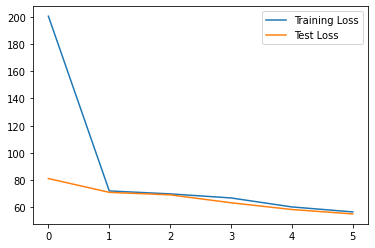

LOSS of the network on the test images: 978 %
Mean of the network on the Indian images after epoch 5 is 54.38712904188368
LOSS of the network on the test images: 1066 %
Mean of the network on the Western images after epoch 5 is 59.24876721700033


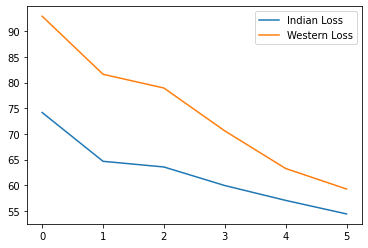

[7,     1] loss: 57.179
[7,     2] loss: 56.558
[7,     3] loss: 47.969
[7,     4] loss: 50.452
[7,     5] loss: 52.927
[7,     6] loss: 52.798
[7,     7] loss: 52.521
[7,     8] loss: 58.344
[7,     9] loss: 53.608
[7,    10] loss: 58.362
[7,    11] loss: 61.874
[7,    12] loss: 58.969
[7,    13] loss: 51.393
[7,    14] loss: 53.606
[7,    15] loss: 58.812
[7,    16] loss: 52.993
[7,    17] loss: 58.193
[7,    18] loss: 56.813
[7,    19] loss: 46.305
[7,    20] loss: 57.211
[7,    21] loss: 55.051
[7,    22] loss: 52.005
[7,    23] loss: 57.013
[7,    24] loss: 48.103
[7,    25] loss: 52.882
[7,    26] loss: 47.044
[7,    27] loss: 55.592
[7,    28] loss: 50.964
[7,    29] loss: 56.032
[7,    30] loss: 51.645
[7,    31] loss: 52.058
[7,    32] loss: 52.934
[7,    33] loss: 50.236
[7,    34] loss: 53.494
[7,    35] loss: 53.080
[7,    36] loss: 60.842
[7,    37] loss: 53.999
[7,    38] loss: 55.500
[7,    39] loss: 54.373
[7,    40] loss: 52.752
[7,    41] loss: 51.071
[7,    42] loss:

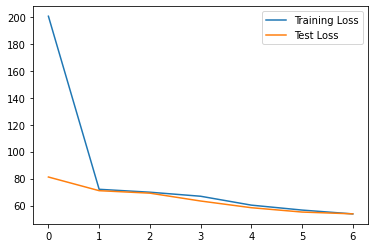

LOSS of the network on the test images: 967 %
Mean of the network on the Indian images after epoch 6 is 53.77547179328071
LOSS of the network on the test images: 1028 %
Mean of the network on the Western images after epoch 6 is 57.11685434977213


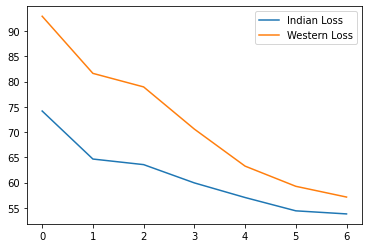

[8,     1] loss: 55.792
[8,     2] loss: 54.905
[8,     3] loss: 46.705
[8,     4] loss: 48.753
[8,     5] loss: 50.830
[8,     6] loss: 51.110
[8,     7] loss: 50.720
[8,     8] loss: 55.132
[8,     9] loss: 51.805
[8,    10] loss: 55.845
[8,    11] loss: 59.540
[8,    12] loss: 56.781
[8,    13] loss: 49.133
[8,    14] loss: 51.697
[8,    15] loss: 56.316
[8,    16] loss: 51.368
[8,    17] loss: 55.460
[8,    18] loss: 54.154
[8,    19] loss: 45.061
[8,    20] loss: 54.631
[8,    21] loss: 53.127
[8,    22] loss: 48.839
[8,    23] loss: 54.880
[8,    24] loss: 46.063
[8,    25] loss: 50.872
[8,    26] loss: 44.672
[8,    27] loss: 53.664
[8,    28] loss: 48.659
[8,    29] loss: 53.651
[8,    30] loss: 49.250
[8,    31] loss: 49.898
[8,    32] loss: 50.829
[8,    33] loss: 47.901
[8,    34] loss: 51.286
[8,    35] loss: 51.294
[8,    36] loss: 58.160
[8,    37] loss: 52.931
[8,    38] loss: 53.188
[8,    39] loss: 52.840
[8,    40] loss: 50.712
[8,    41] loss: 49.717
[8,    42] loss:

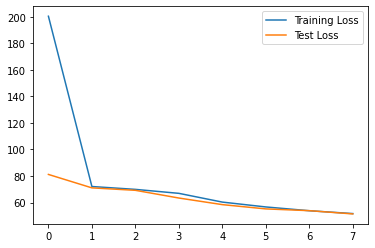

LOSS of the network on the test images: 932 %
Mean of the network on the Indian images after epoch 7 is 51.81909709506564
LOSS of the network on the test images: 972 %
Mean of the network on the Western images after epoch 7 is 54.02088016933865


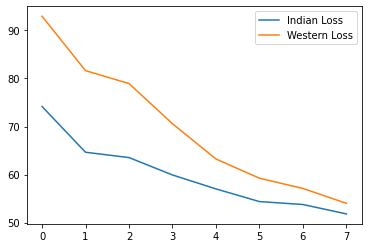

[9,     1] loss: 52.653
[9,     2] loss: 53.703
[9,     3] loss: 44.981
[9,     4] loss: 46.438
[9,     5] loss: 48.630
[9,     6] loss: 49.077
[9,     7] loss: 47.658
[9,     8] loss: 52.137
[9,     9] loss: 48.194
[9,    10] loss: 52.692
[9,    11] loss: 57.866
[9,    12] loss: 54.171
[9,    13] loss: 47.129
[9,    14] loss: 49.962
[9,    15] loss: 53.986
[9,    16] loss: 49.127
[9,    17] loss: 53.012
[9,    18] loss: 51.302
[9,    19] loss: 44.024
[9,    20] loss: 52.345
[9,    21] loss: 50.952
[9,    22] loss: 46.802
[9,    23] loss: 52.199
[9,    24] loss: 44.427
[9,    25] loss: 48.539
[9,    26] loss: 42.801
[9,    27] loss: 51.448
[9,    28] loss: 46.958
[9,    29] loss: 51.147
[9,    30] loss: 46.515
[9,    31] loss: 47.580
[9,    32] loss: 48.829
[9,    33] loss: 46.301
[9,    34] loss: 48.937
[9,    35] loss: 50.027
[9,    36] loss: 55.326
[9,    37] loss: 51.426
[9,    38] loss: 51.266
[9,    39] loss: 51.389
[9,    40] loss: 49.259
[9,    41] loss: 47.933
[9,    42] loss:

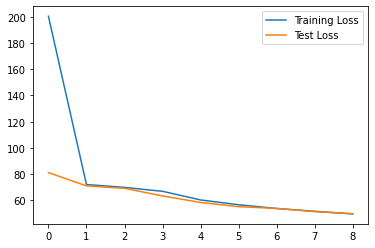

LOSS of the network on the test images: 909 %
Mean of the network on the Indian images after epoch 8 is 50.542086919148765
LOSS of the network on the test images: 937 %
Mean of the network on the Western images after epoch 8 is 52.05625661214193


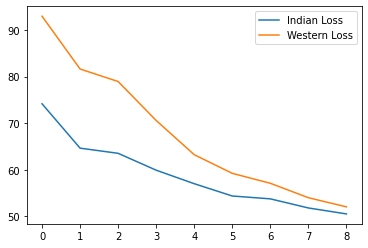

[10,     1] loss: 50.527
[10,     2] loss: 50.874
[10,     3] loss: 43.908
[10,     4] loss: 44.892
[10,     5] loss: 46.879
[10,     6] loss: 47.608
[10,     7] loss: 45.964
[10,     8] loss: 50.134
[10,     9] loss: 46.798
[10,    10] loss: 50.976
[10,    11] loss: 55.642
[10,    12] loss: 52.668
[10,    13] loss: 45.317
[10,    14] loss: 48.406
[10,    15] loss: 52.169
[10,    16] loss: 47.342
[10,    17] loss: 51.071
[10,    18] loss: 49.300
[10,    19] loss: 42.895
[10,    20] loss: 50.959
[10,    21] loss: 49.417
[10,    22] loss: 44.722
[10,    23] loss: 51.051
[10,    24] loss: 42.995
[10,    25] loss: 47.124
[10,    26] loss: 41.312
[10,    27] loss: 49.991
[10,    28] loss: 45.417
[10,    29] loss: 49.991
[10,    30] loss: 45.079
[10,    31] loss: 46.375
[10,    32] loss: 47.239
[10,    33] loss: 44.790
[10,    34] loss: 47.932
[10,    35] loss: 48.813
[10,    36] loss: 53.027
[10,    37] loss: 49.332
[10,    38] loss: 49.683
[10,    39] loss: 49.818
[10,    40] loss: 47.749


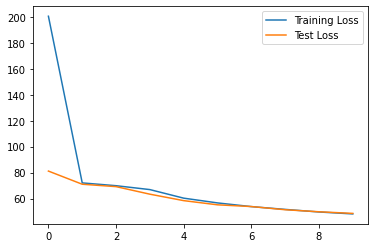

LOSS of the network on the test images: 890 %
Mean of the network on the Indian images after epoch 9 is 49.459236568874786
LOSS of the network on the test images: 910 %
Mean of the network on the Western images after epoch 9 is 50.56428527832031


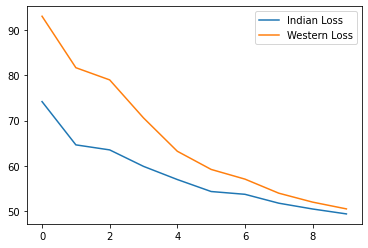

[11,     1] loss: 49.156
[11,     2] loss: 49.550
[11,     3] loss: 41.985
[11,     4] loss: 43.539
[11,     5] loss: 45.314
[11,     6] loss: 46.097
[11,     7] loss: 44.375
[11,     8] loss: 48.393
[11,     9] loss: 44.861
[11,    10] loss: 49.498
[11,    11] loss: 53.910
[11,    12] loss: 51.009
[11,    13] loss: 44.180
[11,    14] loss: 46.722
[11,    15] loss: 50.575
[11,    16] loss: 45.953
[11,    17] loss: 49.623
[11,    18] loss: 47.824
[11,    19] loss: 41.890
[11,    20] loss: 49.430
[11,    21] loss: 48.149
[11,    22] loss: 43.497
[11,    23] loss: 49.692
[11,    24] loss: 41.987
[11,    25] loss: 45.762
[11,    26] loss: 40.126
[11,    27] loss: 48.574
[11,    28] loss: 44.047
[11,    29] loss: 48.317
[11,    30] loss: 43.777
[11,    31] loss: 44.813
[11,    32] loss: 45.988
[11,    33] loss: 43.168
[11,    34] loss: 46.718
[11,    35] loss: 47.397
[11,    36] loss: 51.587
[11,    37] loss: 47.477
[11,    38] loss: 48.381
[11,    39] loss: 48.404
[11,    40] loss: 46.586


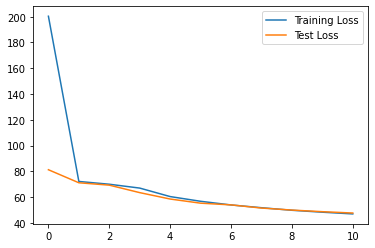

LOSS of the network on the test images: 874 %
Mean of the network on the Indian images after epoch 10 is 48.59294827779134
LOSS of the network on the test images: 887 %
Mean of the network on the Western images after epoch 10 is 49.27822473314073


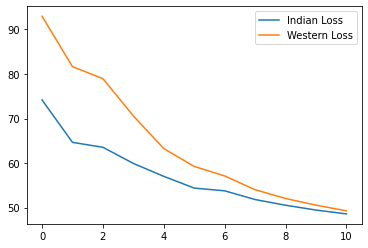

[12,     1] loss: 47.764
[12,     2] loss: 48.535
[12,     3] loss: 41.064
[12,     4] loss: 42.543
[12,     5] loss: 44.244
[12,     6] loss: 45.063
[12,     7] loss: 43.208
[12,     8] loss: 47.116
[12,     9] loss: 43.770
[12,    10] loss: 48.112
[12,    11] loss: 52.422
[12,    12] loss: 49.695
[12,    13] loss: 43.188
[12,    14] loss: 45.441
[12,    15] loss: 49.216
[12,    16] loss: 44.693
[12,    17] loss: 48.268
[12,    18] loss: 46.326
[12,    19] loss: 41.018
[12,    20] loss: 48.168
[12,    21] loss: 46.927
[12,    22] loss: 42.493
[12,    23] loss: 48.442
[12,    24] loss: 41.033
[12,    25] loss: 44.690
[12,    26] loss: 39.130
[12,    27] loss: 47.394
[12,    28] loss: 42.790
[12,    29] loss: 46.884
[12,    30] loss: 42.731
[12,    31] loss: 43.627
[12,    32] loss: 44.640
[12,    33] loss: 42.104
[12,    34] loss: 45.369
[12,    35] loss: 46.302
[12,    36] loss: 50.008
[12,    37] loss: 46.311
[12,    38] loss: 46.889
[12,    39] loss: 47.325
[12,    40] loss: 45.278


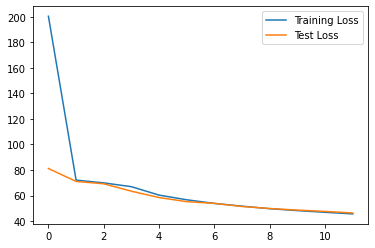

LOSS of the network on the test images: 856 %
Mean of the network on the Indian images after epoch 11 is 47.584860271877716
LOSS of the network on the test images: 860 %
Mean of the network on the Western images after epoch 11 is 47.823818842569985


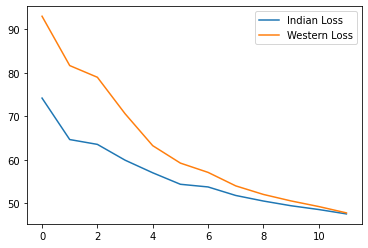

[13,     1] loss: 46.282
[13,     2] loss: 47.237
[13,     3] loss: 40.581
[13,     4] loss: 41.642
[13,     5] loss: 43.041
[13,     6] loss: 43.790
[13,     7] loss: 42.109
[13,     8] loss: 45.593
[13,     9] loss: 42.669
[13,    10] loss: 47.102
[13,    11] loss: 50.765
[13,    12] loss: 48.176
[13,    13] loss: 42.267
[13,    14] loss: 44.071
[13,    15] loss: 47.638
[13,    16] loss: 43.648
[13,    17] loss: 46.682
[13,    18] loss: 44.740
[13,    19] loss: 40.052
[13,    20] loss: 46.866
[13,    21] loss: 45.419
[13,    22] loss: 41.306
[13,    23] loss: 47.323
[13,    24] loss: 39.748
[13,    25] loss: 43.472
[13,    26] loss: 38.145
[13,    27] loss: 46.096
[13,    28] loss: 41.681
[13,    29] loss: 45.443
[13,    30] loss: 41.632
[13,    31] loss: 42.431
[13,    32] loss: 43.243
[13,    33] loss: 40.907
[13,    34] loss: 44.007
[13,    35] loss: 44.862
[13,    36] loss: 48.572
[13,    37] loss: 45.043
[13,    38] loss: 45.289
[13,    39] loss: 45.698
[13,    40] loss: 44.115


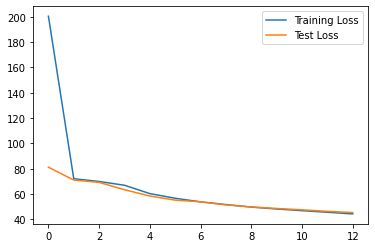

LOSS of the network on the test images: 840 %
Mean of the network on the Indian images after epoch 12 is 46.71195835537381
LOSS of the network on the test images: 839 %
Mean of the network on the Western images after epoch 12 is 46.634482277764214


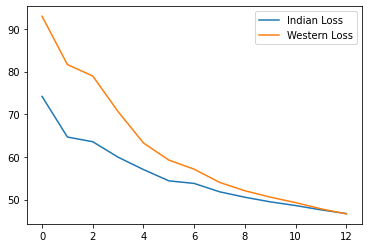

[14,     1] loss: 44.959
[14,     2] loss: 45.711
[14,     3] loss: 38.868
[14,     4] loss: 40.550
[14,     5] loss: 41.908
[14,     6] loss: 42.627
[14,     7] loss: 40.720
[14,     8] loss: 44.352
[14,     9] loss: 41.176
[14,    10] loss: 45.991
[14,    11] loss: 50.362
[14,    12] loss: 47.451
[14,    13] loss: 42.821
[14,    14] loss: 43.600
[14,    15] loss: 46.754
[14,    16] loss: 42.695
[14,    17] loss: 45.157
[14,    18] loss: 43.890
[14,    19] loss: 39.608
[14,    20] loss: 46.164
[14,    21] loss: 44.133
[14,    22] loss: 41.173
[14,    23] loss: 47.034
[14,    24] loss: 38.711
[14,    25] loss: 43.147
[14,    26] loss: 39.337
[14,    27] loss: 45.185
[14,    28] loss: 41.532
[14,    29] loss: 46.014
[14,    30] loss: 40.970
[14,    31] loss: 41.561
[14,    32] loss: 43.083
[14,    33] loss: 39.918
[14,    34] loss: 43.329
[14,    35] loss: 44.738
[14,    36] loss: 47.106
[14,    37] loss: 45.970
[14,    38] loss: 46.527
[14,    39] loss: 44.662
[14,    40] loss: 44.769


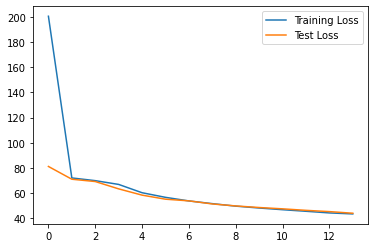

LOSS of the network on the test images: 820 %
Mean of the network on the Indian images after epoch 13 is 45.55951860215929
LOSS of the network on the test images: 812 %
Mean of the network on the Western images after epoch 13 is 45.1386472913954


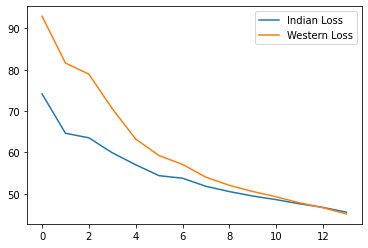

[15,     1] loss: 43.365
[15,     2] loss: 44.244
[15,     3] loss: 37.752
[15,     4] loss: 39.054
[15,     5] loss: 40.625
[15,     6] loss: 40.919
[15,     7] loss: 39.355
[15,     8] loss: 42.628
[15,     9] loss: 39.855
[15,    10] loss: 44.562
[15,    11] loss: 48.290
[15,    12] loss: 45.172
[15,    13] loss: 40.302
[15,    14] loss: 41.397
[15,    15] loss: 45.199
[15,    16] loss: 41.177
[15,    17] loss: 43.832
[15,    18] loss: 41.591
[15,    19] loss: 38.264
[15,    20] loss: 44.313
[15,    21] loss: 42.710
[15,    22] loss: 38.966
[15,    23] loss: 44.604
[15,    24] loss: 37.409
[15,    25] loss: 41.163
[15,    26] loss: 35.916
[15,    27] loss: 43.927
[15,    28] loss: 39.891
[15,    29] loss: 42.673
[15,    30] loss: 39.599
[15,    31] loss: 40.123
[15,    32] loss: 40.560
[15,    33] loss: 38.798
[15,    34] loss: 41.861
[15,    35] loss: 41.897
[15,    36] loss: 44.817
[15,    37] loss: 42.743
[15,    38] loss: 42.693
[15,    39] loss: 42.934
[15,    40] loss: 42.205


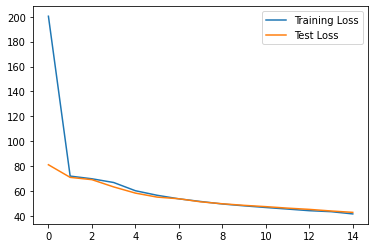

LOSS of the network on the test images: 802 %
Mean of the network on the Indian images after epoch 14 is 44.591468811035156
LOSS of the network on the test images: 788 %
Mean of the network on the Western images after epoch 14 is 43.82133420308431


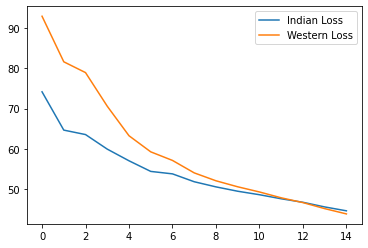

[16,     1] loss: 41.849
[16,     2] loss: 43.057
[16,     3] loss: 37.164
[16,     4] loss: 38.119
[16,     5] loss: 39.458
[16,     6] loss: 39.538
[16,     7] loss: 38.253
[16,     8] loss: 40.931
[16,     9] loss: 38.904
[16,    10] loss: 43.141
[16,    11] loss: 46.885
[16,    12] loss: 43.544
[16,    13] loss: 38.769
[16,    14] loss: 40.003
[16,    15] loss: 43.586
[16,    16] loss: 39.970
[16,    17] loss: 41.900
[16,    18] loss: 40.179
[16,    19] loss: 36.651
[16,    20] loss: 42.844
[16,    21] loss: 40.953
[16,    22] loss: 37.708
[16,    23] loss: 43.037
[16,    24] loss: 36.225
[16,    25] loss: 39.711
[16,    26] loss: 34.673
[16,    27] loss: 42.423
[16,    28] loss: 38.111
[16,    29] loss: 41.324
[16,    30] loss: 38.256
[16,    31] loss: 38.437
[16,    32] loss: 39.319
[16,    33] loss: 37.401
[16,    34] loss: 40.122
[16,    35] loss: 40.702
[16,    36] loss: 43.114
[16,    37] loss: 40.766
[16,    38] loss: 41.206
[16,    39] loss: 41.848
[16,    40] loss: 40.275


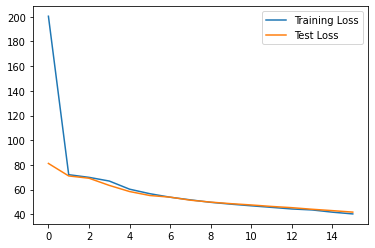

LOSS of the network on the test images: 783 %
Mean of the network on the Indian images after epoch 15 is 43.50348663330078
LOSS of the network on the test images: 764 %
Mean of the network on the Western images after epoch 15 is 42.45100572374132


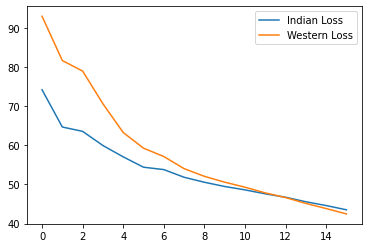

[17,     1] loss: 40.279
[17,     2] loss: 41.276
[17,     3] loss: 35.997
[17,     4] loss: 37.690
[17,     5] loss: 39.290
[17,     6] loss: 38.808
[17,     7] loss: 37.602
[17,     8] loss: 40.018
[17,     9] loss: 37.784
[17,    10] loss: 41.556
[17,    11] loss: 46.030
[17,    12] loss: 43.248
[17,    13] loss: 38.592
[17,    14] loss: 39.083
[17,    15] loss: 42.699
[17,    16] loss: 39.138
[17,    17] loss: 40.839
[17,    18] loss: 39.145
[17,    19] loss: 35.879
[17,    20] loss: 41.746
[17,    21] loss: 40.057
[17,    22] loss: 37.354
[17,    23] loss: 42.163
[17,    24] loss: 35.776
[17,    25] loss: 40.356
[17,    26] loss: 34.039
[17,    27] loss: 41.194
[17,    28] loss: 37.365
[17,    29] loss: 41.102
[17,    30] loss: 37.951
[17,    31] loss: 37.287
[17,    32] loss: 38.570
[17,    33] loss: 37.043
[17,    34] loss: 38.685
[17,    35] loss: 39.428
[17,    36] loss: 41.356
[17,    37] loss: 40.230
[17,    38] loss: 40.149
[17,    39] loss: 41.179
[17,    40] loss: 39.178


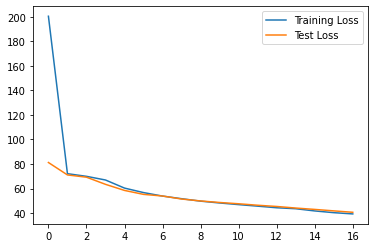

LOSS of the network on the test images: 763 %
Mean of the network on the Indian images after epoch 16 is 42.43508635626899
LOSS of the network on the test images: 740 %
Mean of the network on the Western images after epoch 16 is 41.153154373168945


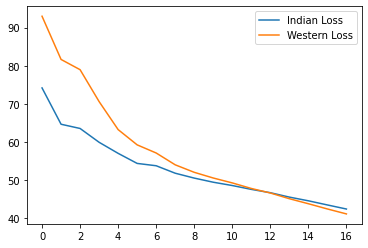

[18,     1] loss: 38.789
[18,     2] loss: 40.107
[18,     3] loss: 35.472
[18,     4] loss: 36.043
[18,     5] loss: 37.008
[18,     6] loss: 37.133
[18,     7] loss: 35.822
[18,     8] loss: 37.952
[18,     9] loss: 36.573
[18,    10] loss: 40.434
[18,    11] loss: 44.348
[18,    12] loss: 40.726
[18,    13] loss: 35.953
[18,    14] loss: 37.009
[18,    15] loss: 40.753
[18,    16] loss: 37.529
[18,    17] loss: 38.880
[18,    18] loss: 37.501
[18,    19] loss: 34.329
[18,    20] loss: 40.209
[18,    21] loss: 37.824
[18,    22] loss: 35.054
[18,    23] loss: 40.107
[18,    24] loss: 33.783
[18,    25] loss: 36.993
[18,    26] loss: 32.286
[18,    27] loss: 39.667
[18,    28] loss: 35.348
[18,    29] loss: 38.435
[18,    30] loss: 35.870
[18,    31] loss: 35.845
[18,    32] loss: 36.320
[18,    33] loss: 35.376
[18,    34] loss: 37.300
[18,    35] loss: 37.530
[18,    36] loss: 39.511
[18,    37] loss: 38.170
[18,    38] loss: 38.207
[18,    39] loss: 38.934
[18,    40] loss: 37.701


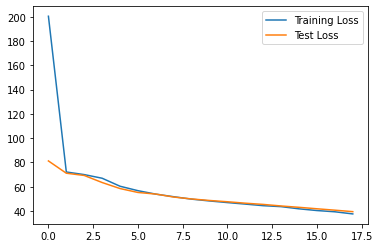

LOSS of the network on the test images: 743 %
Mean of the network on the Indian images after epoch 17 is 41.27808231777615
LOSS of the network on the test images: 716 %
Mean of the network on the Western images after epoch 17 is 39.807548946804474


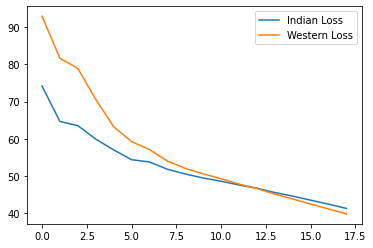

[19,     1] loss: 37.141
[19,     2] loss: 38.358
[19,     3] loss: 34.064
[19,     4] loss: 35.414
[19,     5] loss: 36.220
[19,     6] loss: 35.263
[19,     7] loss: 34.363
[19,     8] loss: 36.608
[19,     9] loss: 34.763
[19,    10] loss: 38.105
[19,    11] loss: 42.141
[19,    12] loss: 39.015
[19,    13] loss: 34.442
[19,    14] loss: 35.641
[19,    15] loss: 39.389
[19,    16] loss: 36.465
[19,    17] loss: 37.408
[19,    18] loss: 36.122
[19,    19] loss: 33.178
[19,    20] loss: 38.836
[19,    21] loss: 36.352
[19,    22] loss: 33.716
[19,    23] loss: 38.757
[19,    24] loss: 32.515
[19,    25] loss: 35.573
[19,    26] loss: 31.168
[19,    27] loss: 38.342
[19,    28] loss: 33.981
[19,    29] loss: 36.860
[19,    30] loss: 34.600
[19,    31] loss: 34.674
[19,    32] loss: 34.800
[19,    33] loss: 34.010
[19,    34] loss: 36.415
[19,    35] loss: 36.244
[19,    36] loss: 37.815
[19,    37] loss: 36.655
[19,    38] loss: 37.147
[19,    39] loss: 37.559
[19,    40] loss: 36.172


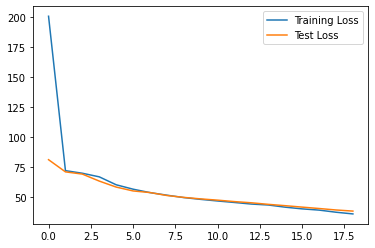

LOSS of the network on the test images: 727 %
Mean of the network on the Indian images after epoch 18 is 40.410665088229706
LOSS of the network on the test images: 697 %
Mean of the network on the Western images after epoch 18 is 38.76911873287625


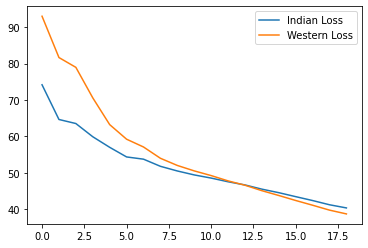

[20,     1] loss: 35.769
[20,     2] loss: 36.631
[20,     3] loss: 32.380
[20,     4] loss: 33.442
[20,     5] loss: 34.841
[20,     6] loss: 33.994
[20,     7] loss: 33.063
[20,     8] loss: 35.046
[20,     9] loss: 33.197
[20,    10] loss: 36.553
[20,    11] loss: 40.214
[20,    12] loss: 37.493
[20,    13] loss: 33.050
[20,    14] loss: 34.184
[20,    15] loss: 37.578
[20,    16] loss: 35.216
[20,    17] loss: 35.818
[20,    18] loss: 34.769
[20,    19] loss: 31.789
[20,    20] loss: 37.250
[20,    21] loss: 34.767
[20,    22] loss: 32.438
[20,    23] loss: 37.154
[20,    24] loss: 31.387
[20,    25] loss: 33.921
[20,    26] loss: 29.615
[20,    27] loss: 36.502
[20,    28] loss: 32.794
[20,    29] loss: 35.412
[20,    30] loss: 33.008
[20,    31] loss: 33.224
[20,    32] loss: 33.332
[20,    33] loss: 32.496
[20,    34] loss: 34.810
[20,    35] loss: 35.050
[20,    36] loss: 36.276
[20,    37] loss: 35.013
[20,    38] loss: 35.451
[20,    39] loss: 36.262
[20,    40] loss: 34.828


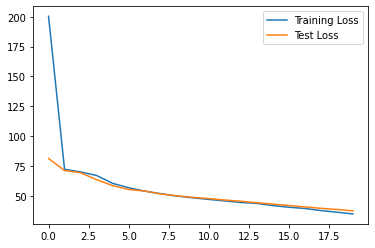

LOSS of the network on the test images: 707 %
Mean of the network on the Indian images after epoch 19 is 39.30349667867025
LOSS of the network on the test images: 673 %
Mean of the network on the Western images after epoch 19 is 37.40374861823188


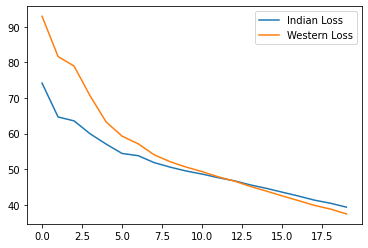

[21,     1] loss: 34.269
[21,     2] loss: 35.113
[21,     3] loss: 31.224
[21,     4] loss: 32.071
[21,     5] loss: 33.693
[21,     6] loss: 32.622
[21,     7] loss: 31.759
[21,     8] loss: 33.308
[21,     9] loss: 31.782
[21,    10] loss: 34.888
[21,    11] loss: 38.555
[21,    12] loss: 35.740
[21,    13] loss: 31.699
[21,    14] loss: 32.682
[21,    15] loss: 36.024
[21,    16] loss: 33.865
[21,    17] loss: 34.285
[21,    18] loss: 33.456
[21,    19] loss: 30.669
[21,    20] loss: 35.831
[21,    21] loss: 33.572
[21,    22] loss: 31.328
[21,    23] loss: 35.831
[21,    24] loss: 30.447
[21,    25] loss: 32.574
[21,    26] loss: 28.600
[21,    27] loss: 35.056
[21,    28] loss: 31.800
[21,    29] loss: 34.295
[21,    30] loss: 31.883
[21,    31] loss: 31.913
[21,    32] loss: 31.990
[21,    33] loss: 31.418
[21,    34] loss: 33.358
[21,    35] loss: 33.817
[21,    36] loss: 34.715
[21,    37] loss: 33.691
[21,    38] loss: 33.745
[21,    39] loss: 34.805
[21,    40] loss: 33.489


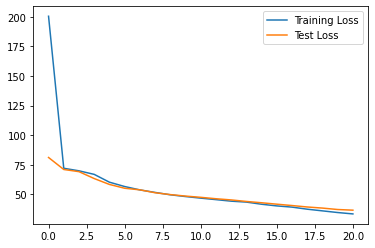

LOSS of the network on the test images: 697 %
Mean of the network on the Indian images after epoch 20 is 38.746493869357636
LOSS of the network on the test images: 662 %
Mean of the network on the Western images after epoch 20 is 36.81103388468424


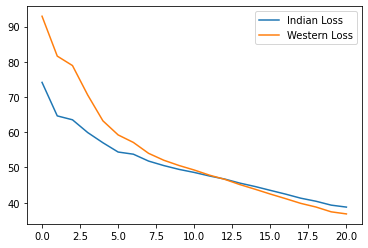

[22,     1] loss: 33.361
[22,     2] loss: 34.022
[22,     3] loss: 30.123
[22,     4] loss: 31.128
[22,     5] loss: 32.450
[22,     6] loss: 31.558
[22,     7] loss: 30.850
[22,     8] loss: 31.985
[22,     9] loss: 30.813
[22,    10] loss: 33.585
[22,    11] loss: 37.041
[22,    12] loss: 34.467
[22,    13] loss: 30.665
[22,    14] loss: 31.616
[22,    15] loss: 34.730
[22,    16] loss: 32.829
[22,    17] loss: 32.990
[22,    18] loss: 32.216
[22,    19] loss: 29.619
[22,    20] loss: 34.631
[22,    21] loss: 32.402
[22,    22] loss: 30.488
[22,    23] loss: 34.809
[22,    24] loss: 29.509
[22,    25] loss: 31.570
[22,    26] loss: 28.333
[22,    27] loss: 34.376
[22,    28] loss: 30.932
[22,    29] loss: 32.940
[22,    30] loss: 31.009
[22,    31] loss: 31.204
[22,    32] loss: 30.798
[22,    33] loss: 30.408
[22,    34] loss: 32.615
[22,    35] loss: 33.434
[22,    36] loss: 33.744
[22,    37] loss: 33.083
[22,    38] loss: 33.161
[22,    39] loss: 34.124
[22,    40] loss: 32.551


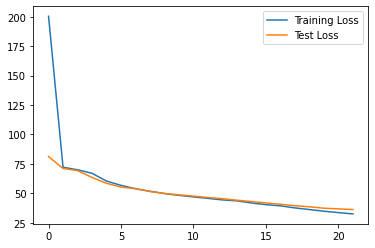

LOSS of the network on the test images: 686 %
Mean of the network on the Indian images after epoch 21 is 38.117621951633026
LOSS of the network on the test images: 653 %
Mean of the network on the Western images after epoch 21 is 36.280226389567055


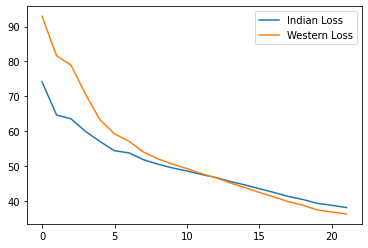

[23,     1] loss: 32.529
[23,     2] loss: 33.183
[23,     3] loss: 30.154
[23,     4] loss: 31.751
[23,     5] loss: 31.642
[23,     6] loss: 30.519
[23,     7] loss: 30.176
[23,     8] loss: 31.324
[23,     9] loss: 29.818
[23,    10] loss: 33.128
[23,    11] loss: 37.387
[23,    12] loss: 37.184
[23,    13] loss: 32.952
[23,    14] loss: 32.126
[23,    15] loss: 34.192
[23,    16] loss: 33.972
[23,    17] loss: 35.630
[23,    18] loss: 34.505
[23,    19] loss: 29.707
[23,    20] loss: 34.810
[23,    21] loss: 33.988
[23,    22] loss: 30.294
[23,    23] loss: 35.623
[23,    24] loss: 29.835
[23,    25] loss: 30.757
[23,    26] loss: 28.239
[23,    27] loss: 33.602
[23,    28] loss: 30.258
[23,    29] loss: 32.649
[23,    30] loss: 30.365
[23,    31] loss: 30.529
[23,    32] loss: 30.070
[23,    33] loss: 29.801
[23,    34] loss: 31.503
[23,    35] loss: 31.873
[23,    36] loss: 32.811
[23,    37] loss: 31.762
[23,    38] loss: 31.436
[23,    39] loss: 32.827
[23,    40] loss: 31.666


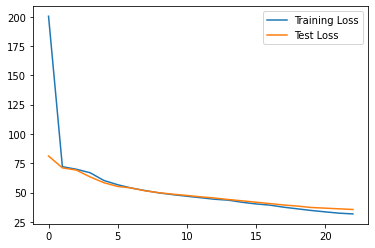

LOSS of the network on the test images: 674 %
Mean of the network on the Indian images after epoch 22 is 37.491058561537
LOSS of the network on the test images: 643 %
Mean of the network on the Western images after epoch 22 is 35.75094350179037


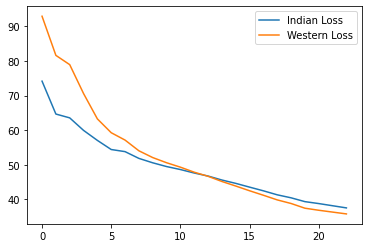

[24,     1] loss: 31.907
[24,     2] loss: 33.970
[24,     3] loss: 29.286
[24,     4] loss: 29.092
[24,     5] loss: 32.082
[24,     6] loss: 31.295
[24,     7] loss: 29.083
[24,     8] loss: 31.683
[24,     9] loss: 30.640
[24,    10] loss: 32.470
[24,    11] loss: 34.944
[24,    12] loss: 33.258
[24,    13] loss: 29.871
[24,    14] loss: 30.339
[24,    15] loss: 33.803
[24,    16] loss: 31.917
[24,    17] loss: 31.595
[24,    18] loss: 31.499
[24,    19] loss: 28.956
[24,    20] loss: 33.333
[24,    21] loss: 32.381
[24,    22] loss: 30.798
[24,    23] loss: 33.376
[24,    24] loss: 29.202
[24,    25] loss: 31.254
[24,    26] loss: 27.028
[24,    27] loss: 32.490
[24,    28] loss: 30.020
[24,    29] loss: 32.422
[24,    30] loss: 30.122
[24,    31] loss: 29.935
[24,    32] loss: 29.733
[24,    33] loss: 29.275
[24,    34] loss: 30.846
[24,    35] loss: 31.097
[24,    36] loss: 31.617
[24,    37] loss: 31.560
[24,    38] loss: 30.493
[24,    39] loss: 31.895
[24,    40] loss: 31.310


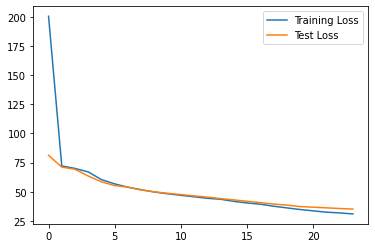

LOSS of the network on the test images: 664 %
Mean of the network on the Indian images after epoch 23 is 36.90519883897569
LOSS of the network on the test images: 635 %
Mean of the network on the Western images after epoch 23 is 35.32678911421034


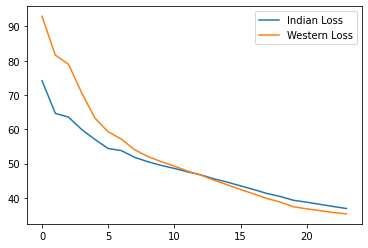

[25,     1] loss: 30.809
[25,     2] loss: 31.989
[25,     3] loss: 27.646
[25,     4] loss: 29.172
[25,     5] loss: 30.835
[25,     6] loss: 28.877
[25,     7] loss: 29.172
[25,     8] loss: 30.175
[25,     9] loss: 28.168
[25,    10] loss: 32.350
[25,    11] loss: 35.671
[25,    12] loss: 31.523
[25,    13] loss: 29.309
[25,    14] loss: 30.173
[25,    15] loss: 32.448
[25,    16] loss: 32.236
[25,    17] loss: 31.117
[25,    18] loss: 29.866
[25,    19] loss: 28.806
[25,    20] loss: 32.133
[25,    21] loss: 30.921
[25,    22] loss: 29.796
[25,    23] loss: 33.314
[25,    24] loss: 27.765
[25,    25] loss: 29.804
[25,    26] loss: 25.960
[25,    27] loss: 31.361
[25,    28] loss: 28.770
[25,    29] loss: 30.796
[25,    30] loss: 29.646
[25,    31] loss: 28.718
[25,    32] loss: 28.717
[25,    33] loss: 28.469
[25,    34] loss: 29.698
[25,    35] loss: 30.539
[25,    36] loss: 30.445
[25,    37] loss: 29.956
[25,    38] loss: 29.536
[25,    39] loss: 30.932
[25,    40] loss: 30.187


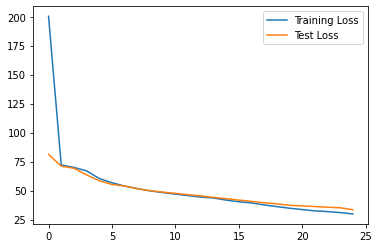

LOSS of the network on the test images: 638 %
Mean of the network on the Indian images after epoch 24 is 35.4803581237793
LOSS of the network on the test images: 599 %
Mean of the network on the Western images after epoch 24 is 33.32622538672553


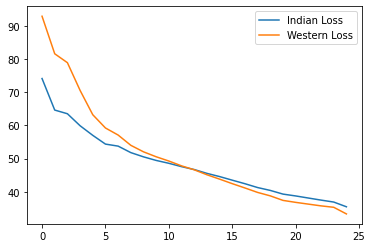

[26,     1] loss: 29.149
[26,     2] loss: 29.733
[26,     3] loss: 26.877
[26,     4] loss: 27.322
[26,     5] loss: 28.442
[26,     6] loss: 27.665
[26,     7] loss: 27.321
[26,     8] loss: 28.164
[26,     9] loss: 27.287
[26,    10] loss: 29.366
[26,    11] loss: 32.144
[26,    12] loss: 30.142
[26,    13] loss: 27.016
[26,    14] loss: 28.086
[26,    15] loss: 31.251
[26,    16] loss: 29.061
[26,    17] loss: 29.419
[26,    18] loss: 28.469
[26,    19] loss: 26.657
[26,    20] loss: 31.017
[26,    21] loss: 29.043
[26,    22] loss: 26.892
[26,    23] loss: 31.024
[26,    24] loss: 26.652
[26,    25] loss: 28.048
[26,    26] loss: 25.644
[26,    27] loss: 29.527
[26,    28] loss: 27.351
[26,    29] loss: 29.553
[26,    30] loss: 27.564
[26,    31] loss: 27.643
[26,    32] loss: 27.609
[26,    33] loss: 27.273
[26,    34] loss: 28.712
[26,    35] loss: 29.254
[26,    36] loss: 29.154
[26,    37] loss: 28.620
[26,    38] loss: 28.072
[26,    39] loss: 29.991
[26,    40] loss: 28.958


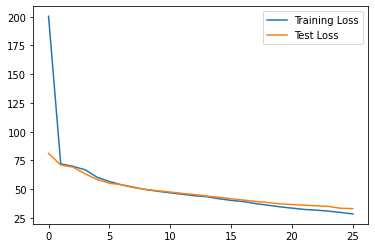

LOSS of the network on the test images: 633 %
Mean of the network on the Indian images after epoch 25 is 35.208524492051865
LOSS of the network on the test images: 595 %
Mean of the network on the Western images after epoch 25 is 33.06224981943766


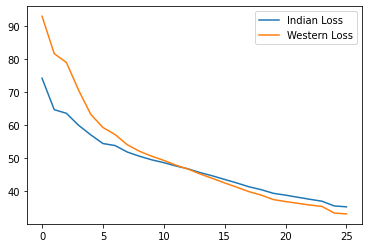

[27,     1] loss: 28.615
[27,     2] loss: 29.165
[27,     3] loss: 26.144
[27,     4] loss: 26.848
[27,     5] loss: 28.197
[27,     6] loss: 26.794
[27,     7] loss: 26.626
[27,     8] loss: 27.592
[27,     9] loss: 26.284
[27,    10] loss: 28.778
[27,    11] loss: 31.276
[27,    12] loss: 28.988
[27,    13] loss: 26.034
[27,    14] loss: 27.157
[27,    15] loss: 29.820
[27,    16] loss: 28.116
[27,    17] loss: 28.184
[27,    18] loss: 27.083
[27,    19] loss: 25.868
[27,    20] loss: 29.587
[27,    21] loss: 27.743
[27,    22] loss: 25.964
[27,    23] loss: 29.842
[27,    24] loss: 25.630
[27,    25] loss: 26.909
[27,    26] loss: 24.152
[27,    27] loss: 28.488
[27,    28] loss: 26.275
[27,    29] loss: 28.332
[27,    30] loss: 26.603
[27,    31] loss: 26.680
[27,    32] loss: 26.304
[27,    33] loss: 26.214
[27,    34] loss: 27.689
[27,    35] loss: 27.947
[27,    36] loss: 28.072
[27,    37] loss: 27.670
[27,    38] loss: 26.824
[27,    39] loss: 28.962
[27,    40] loss: 28.314


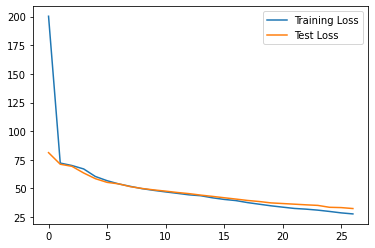

LOSS of the network on the test images: 619 %
Mean of the network on the Indian images after epoch 26 is 34.40545474158393
LOSS of the network on the test images: 578 %
Mean of the network on the Western images after epoch 26 is 32.15460724300809


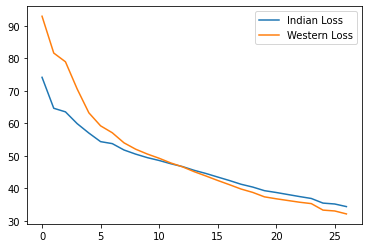

[28,     1] loss: 27.528
[28,     2] loss: 28.308
[28,     3] loss: 25.590
[28,     4] loss: 25.817
[28,     5] loss: 27.122
[28,     6] loss: 26.142
[28,     7] loss: 25.697
[28,     8] loss: 26.631
[28,     9] loss: 25.580
[28,    10] loss: 27.565
[28,    11] loss: 29.896
[28,    12] loss: 28.044
[28,    13] loss: 25.227
[28,    14] loss: 26.392
[28,    15] loss: 28.844
[28,    16] loss: 27.285
[28,    17] loss: 27.287
[28,    18] loss: 26.210
[28,    19] loss: 25.128
[28,    20] loss: 28.570
[28,    21] loss: 26.829
[28,    22] loss: 25.183
[28,    23] loss: 28.846
[28,    24] loss: 24.976
[28,    25] loss: 26.121
[28,    26] loss: 23.495
[28,    27] loss: 27.691
[28,    28] loss: 25.561
[28,    29] loss: 27.556
[28,    30] loss: 25.883
[28,    31] loss: 25.930
[28,    32] loss: 25.600
[28,    33] loss: 25.592
[28,    34] loss: 26.901
[28,    35] loss: 27.193
[28,    36] loss: 27.077
[28,    37] loss: 26.707
[28,    38] loss: 25.963
[28,    39] loss: 28.307
[28,    40] loss: 27.433


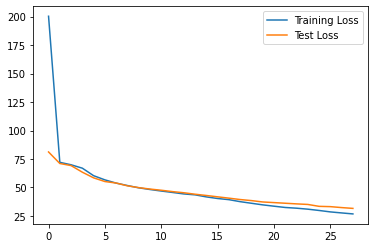

LOSS of the network on the test images: 606 %
Mean of the network on the Indian images after epoch 27 is 33.71778106689453
LOSS of the network on the test images: 565 %
Mean of the network on the Western images after epoch 27 is 31.39189804924859


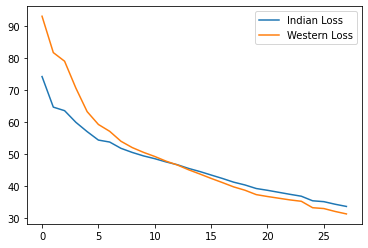

[29,     1] loss: 26.594
[29,     2] loss: 27.336
[29,     3] loss: 24.944
[29,     4] loss: 25.023
[29,     5] loss: 26.228
[29,     6] loss: 25.321
[29,     7] loss: 24.918
[29,     8] loss: 25.700
[29,     9] loss: 24.848
[29,    10] loss: 26.717
[29,    11] loss: 28.905
[29,    12] loss: 27.196
[29,    13] loss: 24.525
[29,    14] loss: 25.607
[29,    15] loss: 27.995
[29,    16] loss: 26.479
[29,    17] loss: 26.475
[29,    18] loss: 25.439
[29,    19] loss: 24.537
[29,    20] loss: 27.821
[29,    21] loss: 25.952
[29,    22] loss: 24.611
[29,    23] loss: 28.136
[29,    24] loss: 24.344
[29,    25] loss: 25.461
[29,    26] loss: 23.127
[29,    27] loss: 26.978
[29,    28] loss: 24.903
[29,    29] loss: 26.868
[29,    30] loss: 25.246
[29,    31] loss: 25.247
[29,    32] loss: 24.805
[29,    33] loss: 24.879
[29,    34] loss: 26.214
[29,    35] loss: 26.380
[29,    36] loss: 26.253
[29,    37] loss: 26.057
[29,    38] loss: 25.228
[29,    39] loss: 27.410
[29,    40] loss: 26.650


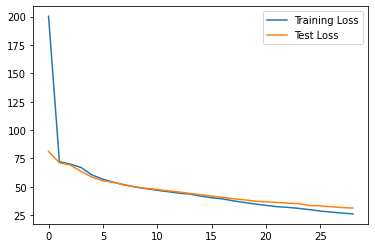

LOSS of the network on the test images: 598 %
Mean of the network on the Indian images after epoch 28 is 33.2357292175293
LOSS of the network on the test images: 557 %
Mean of the network on the Western images after epoch 28 is 30.958709928724502


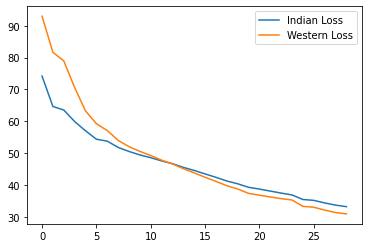

[30,     1] loss: 25.859
[30,     2] loss: 26.497
[30,     3] loss: 24.344
[30,     4] loss: 24.294
[30,     5] loss: 25.594
[30,     6] loss: 24.649
[30,     7] loss: 24.247
[30,     8] loss: 24.908
[30,     9] loss: 24.075
[30,    10] loss: 25.935
[30,    11] loss: 27.913
[30,    12] loss: 26.309
[30,    13] loss: 23.848
[30,    14] loss: 24.864
[30,    15] loss: 27.203
[30,    16] loss: 25.678
[30,    17] loss: 25.687
[30,    18] loss: 24.652
[30,    19] loss: 23.918
[30,    20] loss: 27.027
[30,    21] loss: 25.207
[30,    22] loss: 24.132
[30,    23] loss: 27.675
[30,    24] loss: 23.762
[30,    25] loss: 24.816
[30,    26] loss: 22.978
[30,    27] loss: 26.441
[30,    28] loss: 24.282
[30,    29] loss: 26.194
[30,    30] loss: 24.740
[30,    31] loss: 24.662
[30,    32] loss: 24.138
[30,    33] loss: 24.253
[30,    34] loss: 25.541
[30,    35] loss: 25.706
[30,    36] loss: 25.404
[30,    37] loss: 25.218
[30,    38] loss: 24.371
[30,    39] loss: 26.674
[30,    40] loss: 25.882


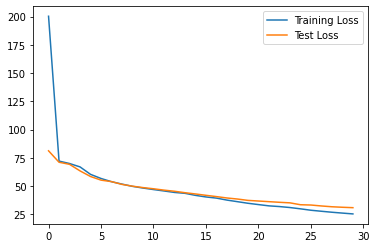

LOSS of the network on the test images: 591 %
Mean of the network on the Indian images after epoch 29 is 32.84971152411567
LOSS of the network on the test images: 550 %
Mean of the network on the Western images after epoch 29 is 30.594224399990505


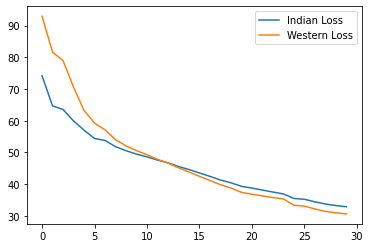

Finished Training


In [29]:
train_loss_graph = []
test_loss_graph = []

indian_loss_graph = []
western_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    if reduction_loss == "mean":
      total_Loss = total_Loss/i
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(testloader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
      
    
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)


    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(indian_loader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the Indian images after epoch {} is {}'.format(epoch, total_Loss) )

    indian_loss_graph.append(total_Loss)

    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(western_loader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the Western images after epoch {} is {}'.format(epoch, total_Loss) )

    western_loss_graph.append(total_Loss)

    visualize_class_loss(indian_loss_graph, western_loss_graph)
          

print('Finished Training')

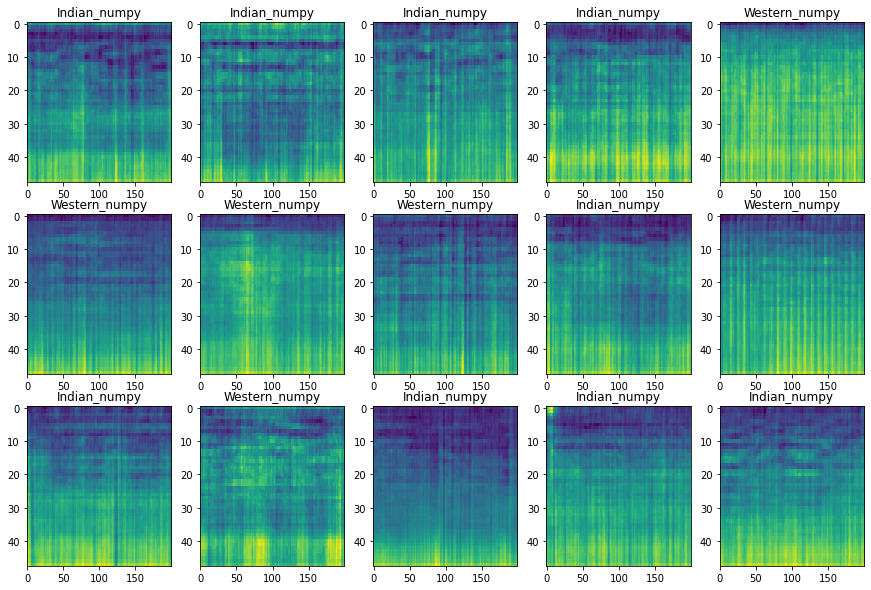

In [30]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

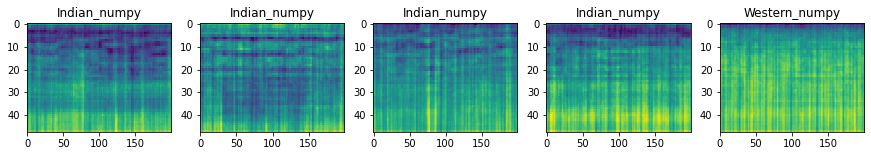

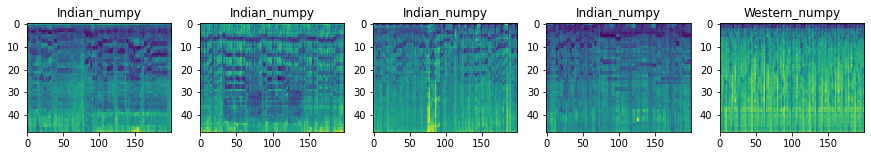

In [31]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [32]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [33]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

<All keys matched successfully>

Combined data set recinstruction

In [34]:
combined_dataset = MEL_Dataset(dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
combinedloader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size)

In [ ]:
# dataDF
# dataDF.loc[1, 'labels']
# classes
# os.path.join(BASE_PATH, "Activations_64", str(classes[label]))

In [ ]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [ ]:
id = 0
with torch.no_grad():
    for data in combinedloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        for  arr64, arr128, arr48, label in zip(output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", classes[label] ,  str(id) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", classes[label] ,  str(id) + ".npy"), np.transpose(arr48, (1,0)))
          id = id + 1

Strict data separation

In [51]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "test", str(class_))
  #print("removing ", dir)
  for f in os.listdir(dir):
    #print("removing ", os.path.join(dir, f))
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [ ]:
id_test = 0
with torch.no_grad():
    for data_test in testloader:
        inputs, labels, fileNames = data_test
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "test", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "test",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "test",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "test",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_test = id_test + 1




In [ ]:
id_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "training", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "training",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "training",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "training",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "training",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_train = id_train + 1